# 1-2，图片数据建模流程范例
## 一，准备数据
cifar2数据集为cifar10数据集的子集，只包括前两种类别的飞机和汽车。

训练集有飞机和汽车图片各5000张，测试集有飞机和汽车图片各1000张。

cifar2任务的目标是训练一个模型来对飞机airplane和放置automobile两种图片进行分类。

我们准备的Cifar2数据集的文件结构如下所示。

![image.png](attachment:../datacifar2_datasets.png)


在tensorflow中准备图片数据的常用方案有两种，第一种是使用tf.keras中的ImageDataGenerator工具构建图片数据生成器。

第二种是使用tf.data.Dataset搭配tf.image中的一些图片处理方法构建数据管道。

第一种方法更为简单，其使用范例可以参考以下文章。

https://zhuanlan.zhihu.com/p/67466552

第二种方法是TensorFlow的原生方法，更加灵活，使用得当的话也可以获得更好的性能。

我们此处介绍第二种方法。

In [1]:
import tensorflow as tf 
from tensorflow.keras import datasets,layers,models

BATCH_SIZE = 100

def load_image(img_path,size = (32,32)):
    label = tf.constant(1,tf.int8) if tf.strings.regex_full_match(img_path,".*automobile.*") \
            else tf.constant(0,tf.int8)
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img) #注意此处为jpeg格式
    img = tf.image.resize(img,size)/255.0
    return(img,label)

In [2]:
#使用并行化预处理num_parallel_calls 和预存数据prefetch来提升性能
ds_train = tf.data.Dataset.list_files("../data/cifar2/train/*/*.jpg") \
           .map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE) \
           .shuffle(buffer_size = 1000).batch(BATCH_SIZE) \
           .prefetch(tf.data.experimental.AUTOTUNE)  

ds_test = tf.data.Dataset.list_files("../data/cifar2/test/*/*.jpg") \
           .map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE) \
           .batch(BATCH_SIZE) \
           .prefetch(tf.data.experimental.AUTOTUNE)  

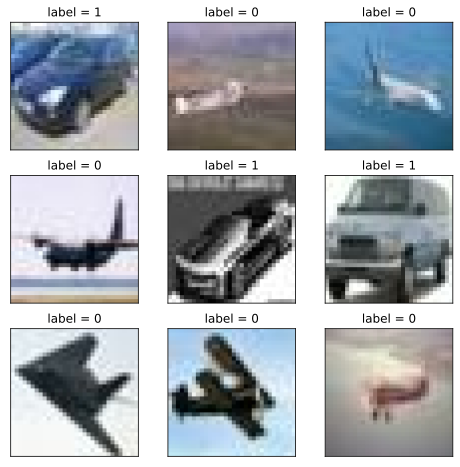

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

#查看部分样本
from matplotlib import pyplot as plt 

plt.figure(figsize=(8,8)) 
for i,(img,label) in enumerate(ds_train.unbatch().take(9)):
    ax=plt.subplot(3,3,i+1)
    ax.imshow(img.numpy())
    ax.set_title("label = %d"%label)
    ax.set_xticks([])
    ax.set_yticks([]) 
plt.show()

In [4]:
for x,y in ds_train.take(1):
    print(x.shape,y.shape)

(100, 32, 32, 3) (100,)


## 二，定义模型
使用Keras接口有以下3种方式构建模型：使用Sequential按层顺序构建模型，使用函数式API构建任意结构模型，继承Model基类构建自定义模型。

此处选择使用函数式API构建模型。

In [5]:
tf.keras.backend.clear_session() #清空会话

inputs = layers.Input(shape=(32,32,3))
x = layers.Conv2D(32,kernel_size=(3,3))(inputs)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(64,kernel_size=(5,5))(x)
x = layers.MaxPool2D()(x)
x = layers.Dropout(rate=0.1)(x)
x = layers.Flatten()(x)
x = layers.Dense(32,activation='relu')(x)
outputs = layers.Dense(1,activation = 'sigmoid')(x)

model = models.Model(inputs = inputs,outputs = outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 5, 5, 64)          0     

## 三，训练模型
训练模型通常有3种方法，内置fit方法，内置train_on_batch方法，以及自定义训练循环。此处我们选择最常用也最简单的内置fit方法。

In [6]:
import datetime
import os

stamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
logdir = os.path.join('data', 'autograph', stamp)

## 在 Python3 下建议使用 pathlib 修正各操作系统的路径
# from pathlib import Path
# stamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# logdir = str(Path('./data/autograph/' + stamp))

tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss=tf.keras.losses.binary_crossentropy,
        metrics=["accuracy"]
    )

history = model.fit(ds_train,epochs= 10,validation_data=ds_test,
                    callbacks = [tensorboard_callback],workers = 4)

Epoch 1/10
100/100 [==============================] - 6s 56ms/step - loss: 0.4277 - accuracy: 0.7960 - val_loss: 0.3020 - val_accuracy: 0.8760
Epoch 2/10
100/100 [==============================] - 10s 93ms/step - loss: 0.3001 - accuracy: 0.8737 - val_loss: 0.2444 - val_accuracy: 0.9030
Epoch 3/10
100/100 [==============================] - 10s 94ms/step - loss: 0.2453 - accuracy: 0.8991 - val_loss: 0.2081 - val_accuracy: 0.9200
Epoch 4/10
100/100 [==============================] - 10s 93ms/step - loss: 0.2005 - accuracy: 0.9189 - val_loss: 0.1889 - val_accuracy: 0.9245
Epoch 5/10
100/100 [==============================] - 10s 93ms/step - loss: 0.1746 - accuracy: 0.9312 - val_loss: 0.1762 - val_accuracy: 0.9295
Epoch 6/10
100/100 [==============================] - 9s 92ms/step - loss: 0.1576 - accuracy: 0.9397 - val_loss: 0.1678 - val_accuracy: 0.9345
Epoch 7/10
100/100 [==============================] - 10s 93ms/step - loss: 0.1375 - accuracy: 0.9467 - val_loss: 0.1627 - val_accuracy: 0

## 四，评估模型

In [7]:
%load_ext tensorboard
#%tensorboard --logdir ../data/keras_model

In [8]:
from tensorboard import notebook
notebook.list() 

No known TensorBoard instances running.


In [9]:
#在tensorboard中查看模型
notebook.start("--logdir ../data/keras_model")

In [10]:
import pandas as pd 
dfhistory = pd.DataFrame(history.history)
dfhistory.index = range(1,len(dfhistory) + 1)
dfhistory.index.name = 'epoch'

dfhistory

,loss,accuracy,val_loss,val_accuracy
epoch,,,,
1,0.427676,0.7960,0.301952,0.8760
2,0.300078,0.8737,0.244382,0.9030
3,0.245349,0.8991,0.208081,0.9200
4,0.200519,0.9189,0.188893,0.9245
5,0.174579,0.9312,0.176185,0.9295
6,0.157577,0.9397,0.167751,0.9345
7,0.137528,0.9467,0.162690,0.9375
8,0.118410,0.9526,0.167783,0.9355
9,0.103238,0.9595,0.166236,0.9360


In [11]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

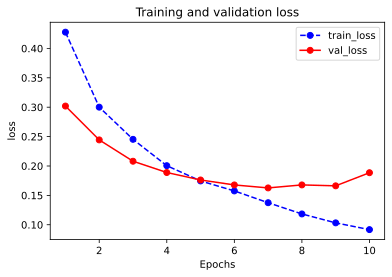

In [12]:
plot_metric(history,"loss")

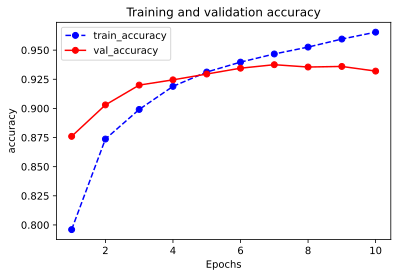

In [13]:
plot_metric(history,"accuracy")

In [14]:
#可以使用evaluate对数据进行评估
val_loss,val_accuracy = model.evaluate(ds_test,workers=4)
print(val_loss,val_accuracy)

20/20 [==============================] - 1s 36ms/step - loss: 0.1886 - accuracy: 0.9320
0.18856826424598694 0.9319999814033508


## 五，使用模型
可以使用model.predict(ds_test)进行预测。

也可以使用model.predict_on_batch(x_test)对一个批量进行预测。

In [15]:
model.predict(ds_test)

array([[9.8065239e-01],
       [7.2932154e-01],
       [9.9892116e-01],
       ...,
       [9.8781437e-01],
       [7.4872375e-04],
       [1.4344781e-05]], dtype=float32)

In [16]:
for x,y in ds_test.take(1):
    print(model.predict_on_batch(x[0:20]))

[[9.9921852e-01]
 [9.9515915e-03]
 [9.8965418e-01]
 [1.3052464e-01]
 [5.7145039e-06]
 [9.9999666e-01]
 [1.4906443e-05]
 [9.9998736e-01]
 [1.7371649e-01]
 [9.9587262e-01]
 [9.5079303e-01]
 [9.9992609e-01]
 [9.9985409e-01]
 [9.7101367e-01]
 [9.9999231e-01]
 [9.5891917e-01]
 [1.7038286e-03]
 [5.0450563e-03]
 [9.9754024e-01]
 [5.8653951e-04]]


## 六，保存模型
推荐使用TensorFlow原生方式保存模型。

In [17]:
# 保存权重，该方式仅仅保存权重张量
model.save_weights('../data/tf_model_weights.ckpt',save_format = "tf")

In [18]:
# 保存模型结构与模型参数到文件,该方式保存的模型具有跨平台性便于部署

model.save('../data/tf_model_savedmodel', save_format="tf")
print('export saved model.')

model_loaded = tf.keras.models.load_model('../data/tf_model_savedmodel')
model_loaded.evaluate(ds_test)

INFO:tensorflow:Assets written to: ../data/tf_model_savedmodel\assets
export saved model.
20/20 [==============================] - 1s 38ms/step - loss: 0.1886 - accuracy: 0.9320


[0.18856827914714813, 0.9319999814033508]